# Modèles de ML sur les données issues des requêtes

In [47]:
# librairies 
#----------------------------------------------
#----- Calculs 
import pandas as pd
import numpy as np
from numpy import mean, std
import numpy.linalg as npl
import math 
from math import sqrt, log
import re #to find integers & floats in a string 
from collections import Counter #to count values in a dataframe or array
#----- Date
from datetime import date, timedelta, datetime #for the date
import datetime as dt
#----- Graphes
import matplotlib.pyplot as plt #to plot graphs
import matplotlib.patches as mpatches #to customize legend
import seaborn as sns #to plot graphs
import pylab 
#----- Machine Learning Preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import scipy.stats as stats
import random
#----- Feature selection
from sklearn.feature_selection import RFECV, RFE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif
#----- Machine Learning Modèles 
from sklearn.tree import DecisionTreeRegressor
#save model 
import pickle 

In [48]:
descriptive_analysis=True

In [49]:
tune_hyperparamters=True #les étapes de tuning sont longues, à mettre True si on veut les réeffectuer

### Récupération & mise en forme des datasets

In [50]:
# Lecture du fichier des données tests
#----------------------------------------------
PATH = '.' #modifier si besoin le chemin du fichier

# récupération du fichier contentant l'ensemble des données issues des requêtes
pricing_requests = pd.read_csv(PATH + '//pricing_requests_done.csv')

# récupération du fichier contenant les features des hotels
hotels = pd.read_csv('features_hotels.csv', index_col=['hotel_id', 'city'])

print("pricing_requests.shape: ",pricing_requests.shape)
pricing_requests.head()

pricing_requests.shape:  (276012, 9)


,hotel_id,price,stock,city,date,language,mobile,avatar_id,request_number
0,105,144,102,amsterdam,39,austrian,1,6056,1.0
1,880,113,81,amsterdam,39,austrian,1,6056,1.0
2,588,172,108,amsterdam,39,austrian,1,6056,1.0
3,352,105,84,amsterdam,39,austrian,1,6056,1.0
4,925,103,83,amsterdam,39,austrian,1,6056,1.0


In [51]:
# Obtenir des features en plus correspondant aux features de l'hotel : on fait une jointure 
#----------------------------------------------
pricing_requests = pricing_requests.join(hotels, on=['hotel_id', 'city'])
pricing_requests.head()

,hotel_id,price,stock,city,date,language,mobile,avatar_id,request_number,group,brand,parking,pool,children_policy
0,105,144,102,amsterdam,39,austrian,1,6056,1.0,Yin Yang,Ardisson,0,0,0
1,880,113,81,amsterdam,39,austrian,1,6056,1.0,Boss Western,Boss Western,0,0,0
2,588,172,108,amsterdam,39,austrian,1,6056,1.0,Independant,Independant,0,0,0
3,352,105,84,amsterdam,39,austrian,1,6056,1.0,Independant,Independant,1,0,0
4,925,103,83,amsterdam,39,austrian,1,6056,1.0,Boss Western,Boss Western,1,0,0


In [52]:
# Assigner le bon type aux variables
#----------------------------------------------
#--- Convert to integer: 
int_list = ["date","avatar_id","hotel_id","stock","request_number","price"] 
pricing_requests[int_list] = pricing_requests[int_list].astype(int) 
#--- Convert to categorical: 
pricing_requests["city"] = pd.Categorical(pricing_requests["city"],ordered=False)
pricing_requests["language"] = pd.Categorical(pricing_requests["language"],ordered=False)
pricing_requests["mobile"] = pd.Categorical(pricing_requests["mobile"],ordered=False)
pricing_requests["parking"] = pd.Categorical(pricing_requests["parking"],ordered=False)
pricing_requests["pool"] = pd.Categorical(pricing_requests["pool"],ordered=False)
pricing_requests["children_policy"] = pd.Categorical(pricing_requests["children_policy"],ordered=False)
pricing_requests["group"] = pd.Categorical(pricing_requests["group"],ordered=False)
pricing_requests["brand"] = pd.Categorical(pricing_requests["brand"],ordered=False)

In [53]:
# Vérification du type des variables
#----------------------------------------------
pricing_requests.dtypes

hotel_id              int32
price                 int32
stock                 int32
city               category
date                  int32
language           category
mobile             category
avatar_id             int32
request_number        int32
group              category
brand              category
parking            category
pool               category
children_policy    category
dtype: object

### Variables langues, city, brand

In [54]:
print("groupes d'hôtels:\n",np.unique(pricing_requests["group"]))
print()
print("brand des hôtels:\n",np.unique(pricing_requests["brand"]))

groupes d'hôtels:
 ['Accar Hotels' 'Boss Western' 'Chillton Worldwide' 'Independant'
 'Morriott International' 'Yin Yang']

brand des hôtels:
 ['8 Premium' 'Ardisson' 'Boss Western' 'Chill Garden Inn' 'Corlton'
 'CourtYord' 'Ibas' 'Independant' 'J.Halliday Inn' 'Marcure' 'Morriot'
 'Navatel' 'Quadrupletree' 'Royal Lotus' 'Safitel' 'Tripletree']


On remarque que "brand" est inclus dans "group". Pour une première analyse, une idée serait de ne garder que la variable "brand".

In [55]:
def plotBar(feature: str): 
    """
    Cette fonction trace le barplot d'une feature  càd le nombre de requêtes effectuées 
    pour chaque modalité de la feature passée en argument. 
    ---> input: 
    * feature (string): nom de la feature dont on veut tracer le barplot.
    """
    dfFeature = pricing_requests[feature].value_counts()
    
    fig, ax1 = plt.subplots(1,figsize=(15,5))
    fig.tight_layout(pad=7)

    ax1.bar(dfFeature.index, dfFeature.values,alpha=.5)

    ax1.set_title("Nombre de requêtes effectuées par " + feature ,pad=20)
    ax1.set_xlabel(feature)
    ax1.set_ylabel("Nombre de requêtes réalisées")
    ax1.set_xticks(np.arange(0,len(dfFeature)))
    ax1.set_xticklabels(dfFeature.index, rotation=90)

    #calcul en pourcentage de requêtes dans les différentes langues 
    perL = 100 * dfFeature.values/sum(dfFeature.values) 

    j=0
    for i, v in enumerate(dfFeature.values):   
        ax1.text(i, v+10, str("%1.1f" % perL[j]) + "%" , ha="center",color = 'slateblue', size = 10, rotation = 0)  
        j+=1

    ax1.spines[['top','right','bottom','left']].set_visible(False)
    plt.show()

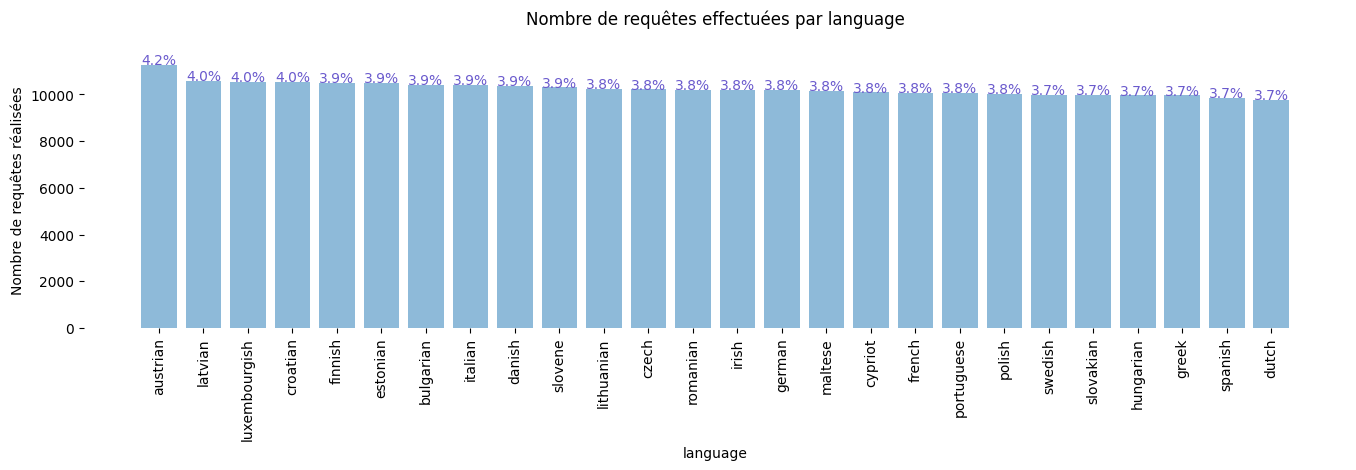

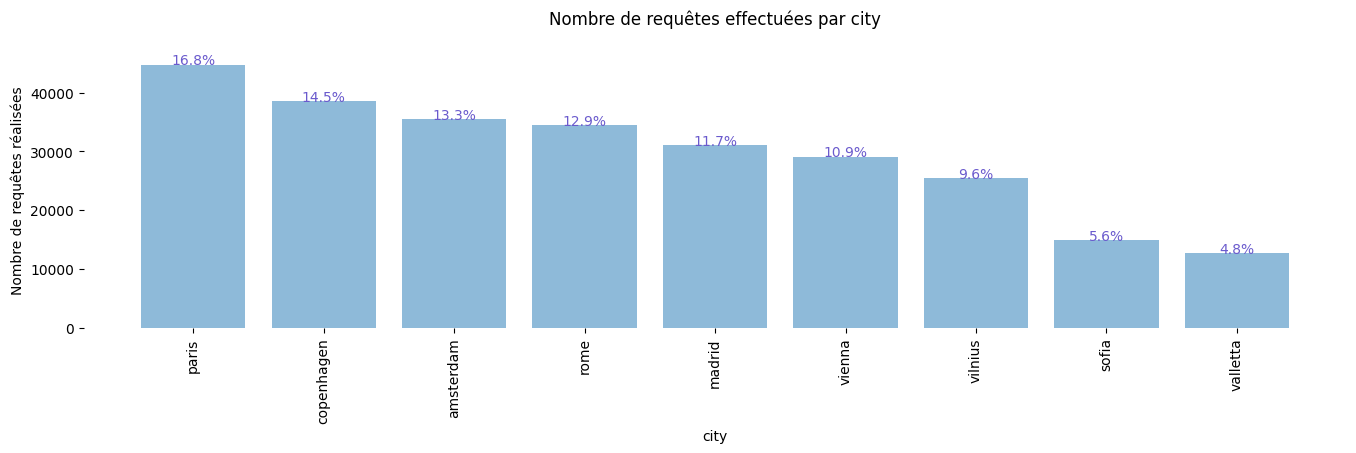

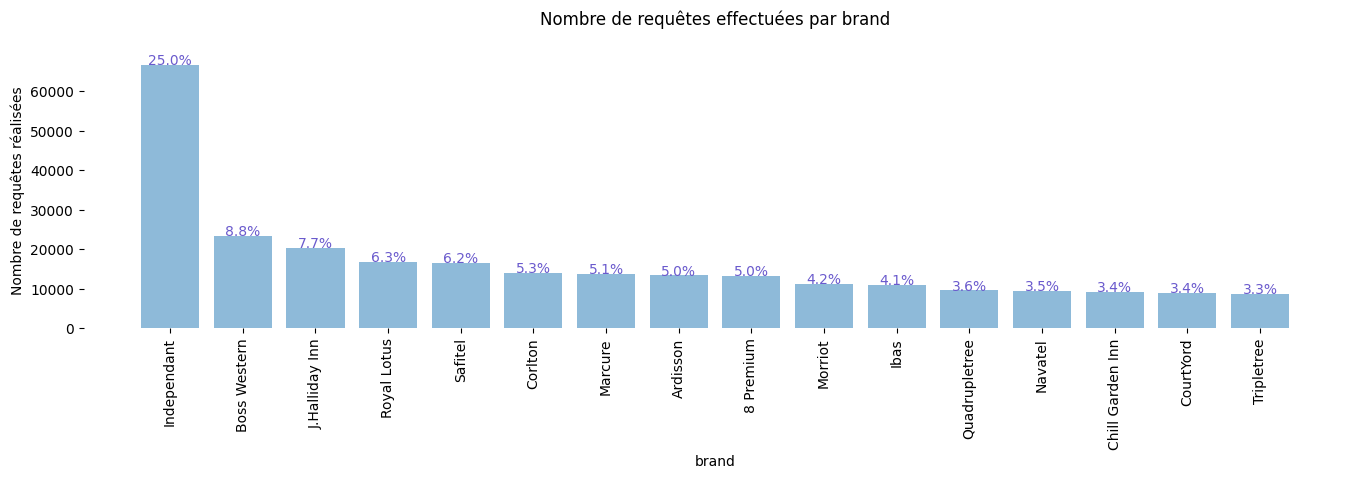

In [10]:
# Tracé des languesn villes et marques présentes dans le dataset
if descriptive_analysis: 
    plotBar('language')
    plotBar('city')
    plotBar('brand')

###  Variable price & stock

In [56]:
def plotHist(feature: str, start: int = 0, 
             stop: int = 500, step: int = 25, 
             bin_width: float = 4, qqPlot: bool = True): 
    """
    Cette fonction trace l'histogramme ainsi que le boxplot d'une feature. 
    ---> input: 
    * feature (string): nom de la feature dont on veut tracer l'histogramme
    * qqPlot  (bool): pemet de tracer ou non le QQ-Plot. 
    * start,stop,step (int): permettent de délimiter le tracer de l'histogramme sur l'axe des abscisses.
    * bin_width (float): permet de changer la taille des bins dans l'histogramme.
    """
    dfFeature = pricing_requests[feature]


    f, (ax1,ax2) = plt.subplots(1,2,figsize=(20, 7),gridspec_kw={'width_ratios': [3, 1]})
    
    flierprops = dict(markerfacecolor='0.75', markersize=4,linestyle='none') #size & color of outliers
    sns.histplot(ax=ax1,data = dfFeature,stat='proportion',
                 binwidth = bin_width,color = 'steelblue', edgecolor = 'w')
    
    ax1.set_xticks(np.linspace(start,stop,step).astype(int))
    ax1.set_ylabel ("Proportion of " + feature)
    ax1.set_title ("Histogram of " + feature)

    sns.boxplot(ax=ax2,y=dfFeature,flierprops=flierprops,linewidth=1)
    ax2.set_title ("Boxplot of " + feature)

    sns.despine(left = True, bottom = True) #remove graph frame
    plt.show()
    
    if qqPlot: 
        fig = plt.subplots(figsize=(8, 5))
        stats.probplot(dfFeature, dist="norm", plot=pylab)
        plt.title("QQ-plot of variable " + feature)
        pylab.show()

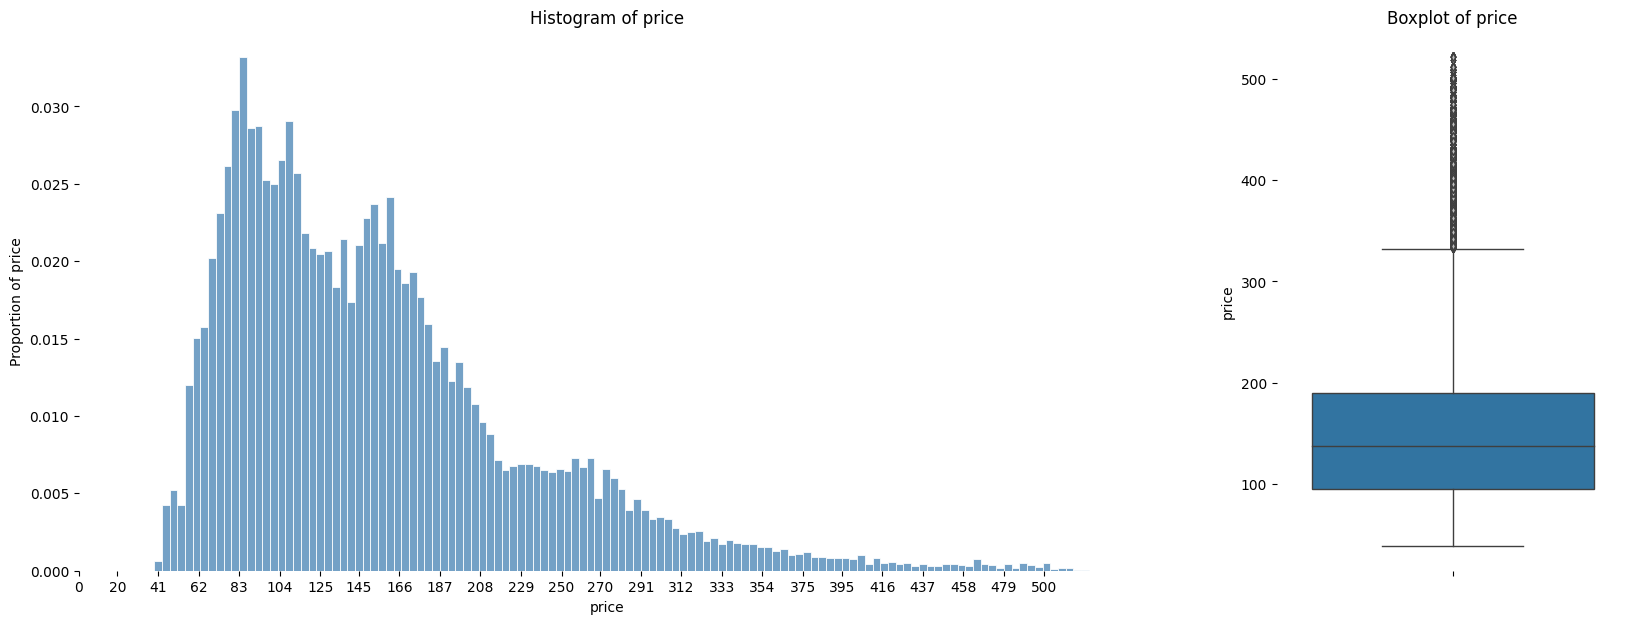

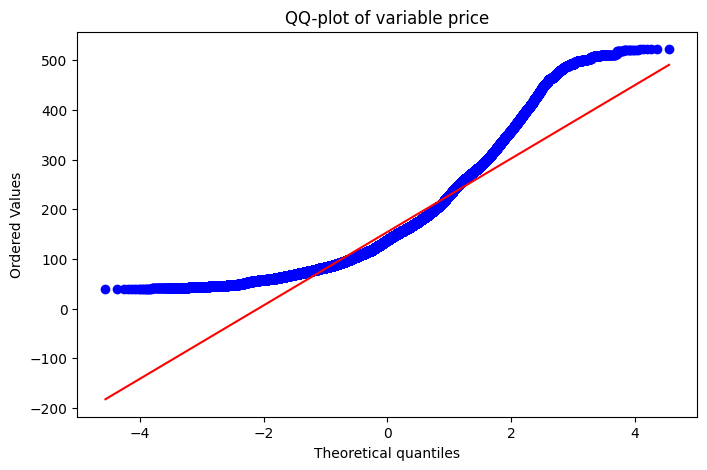

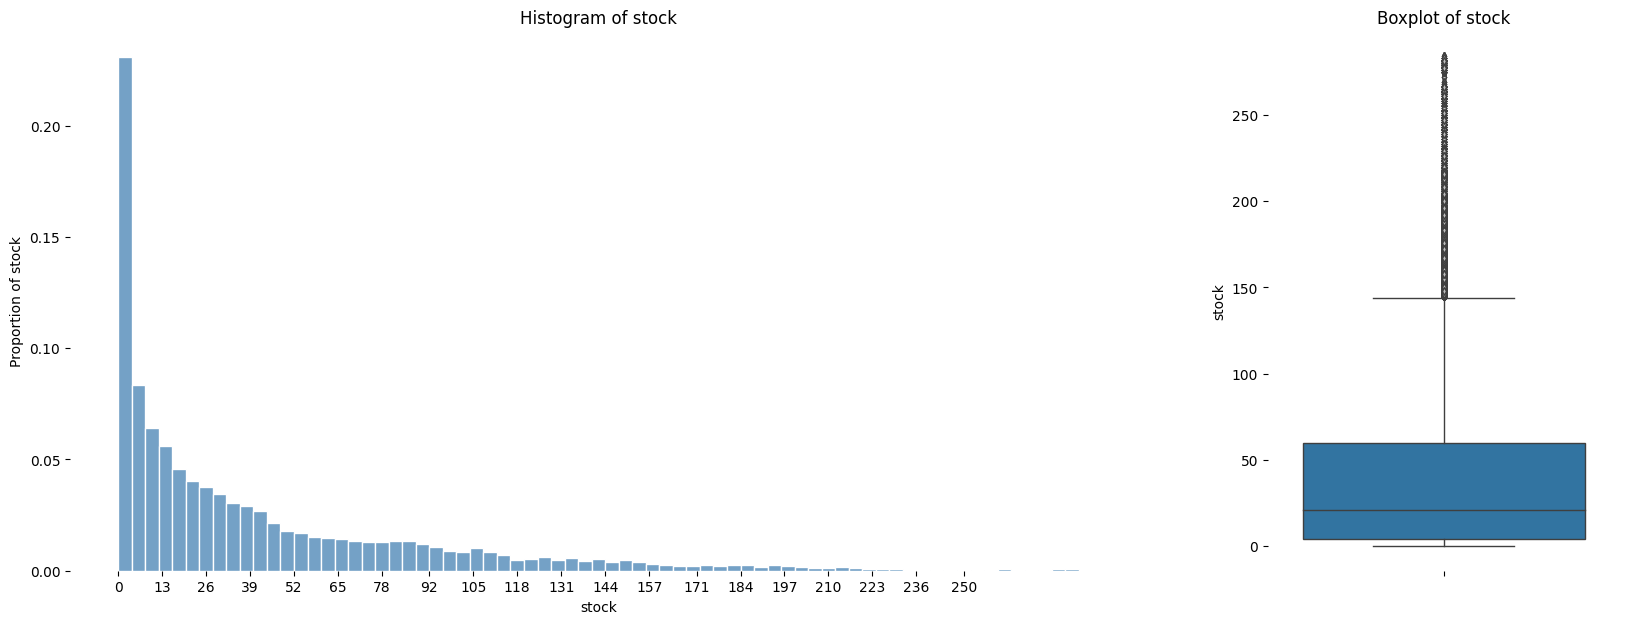

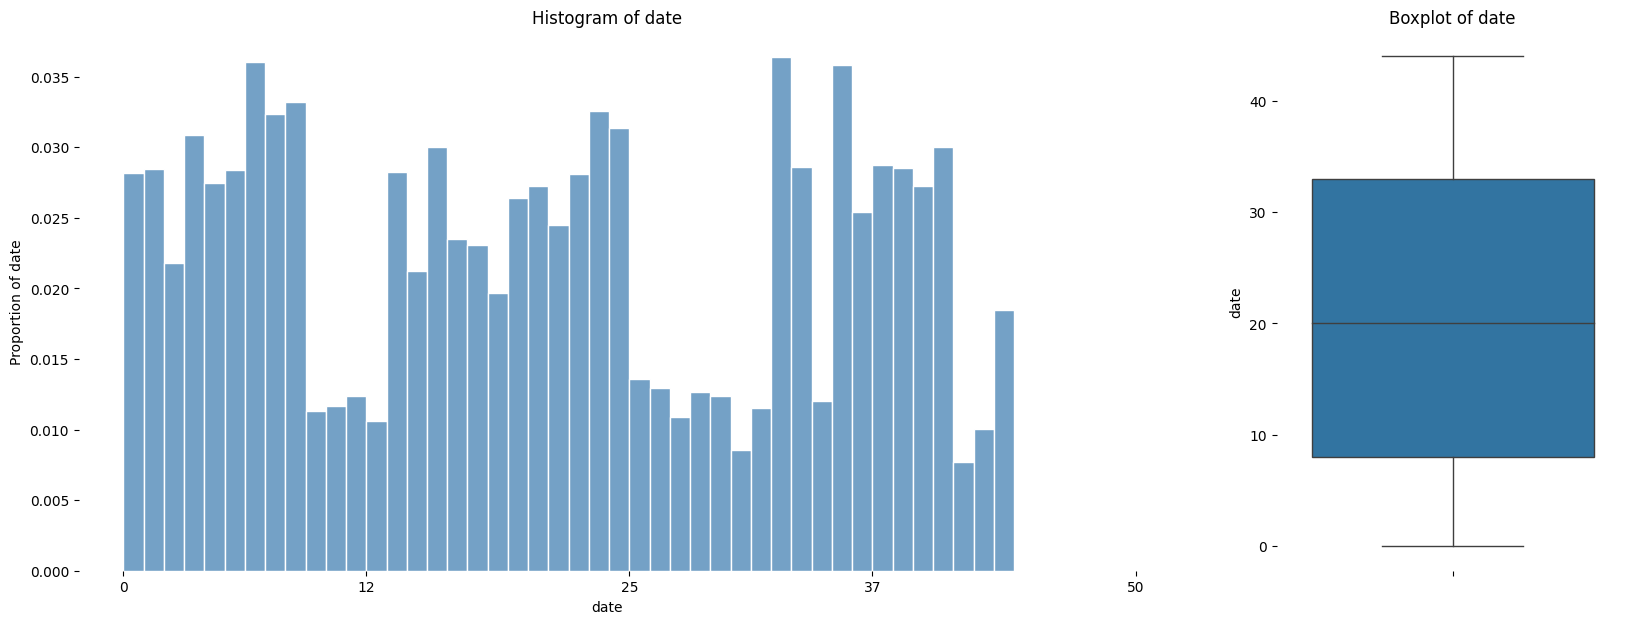

In [12]:
plotHist("price", qqPlot = True)
plotHist("stock",start = 0, stop = 250, step = 20, qqPlot = False)
plotHist("date",start = 0, stop = 50, step = 5, bin_width = 1, qqPlot = False)

Avec les graphes ci-dessus, on voit que `Price` n'est pas une variable gaussienne (mais pourrait s'y apparenter) et `Stock` a davantage l'allure d'une variable exponentielle. La variable `date` ne semble pas avoir de structure particulière.  

### Transformations sur les variables quantitatives 

Nous allons tenter de rendre les variables quantitatives "plus gaussiennes" en leur appliquant des transformations.

In [57]:
# Variables à modifier pour rendre + gaussiennes 
pricing_requests["price"]=pricing_requests["price"].map(lambda x: sqrt(x))
pricing_requests["stock"]=pricing_requests["stock"].map(lambda x: log(x+1)) #log(x+1) car log(0) n'existe pas.

========== Distribution des variable après transformation: ==========


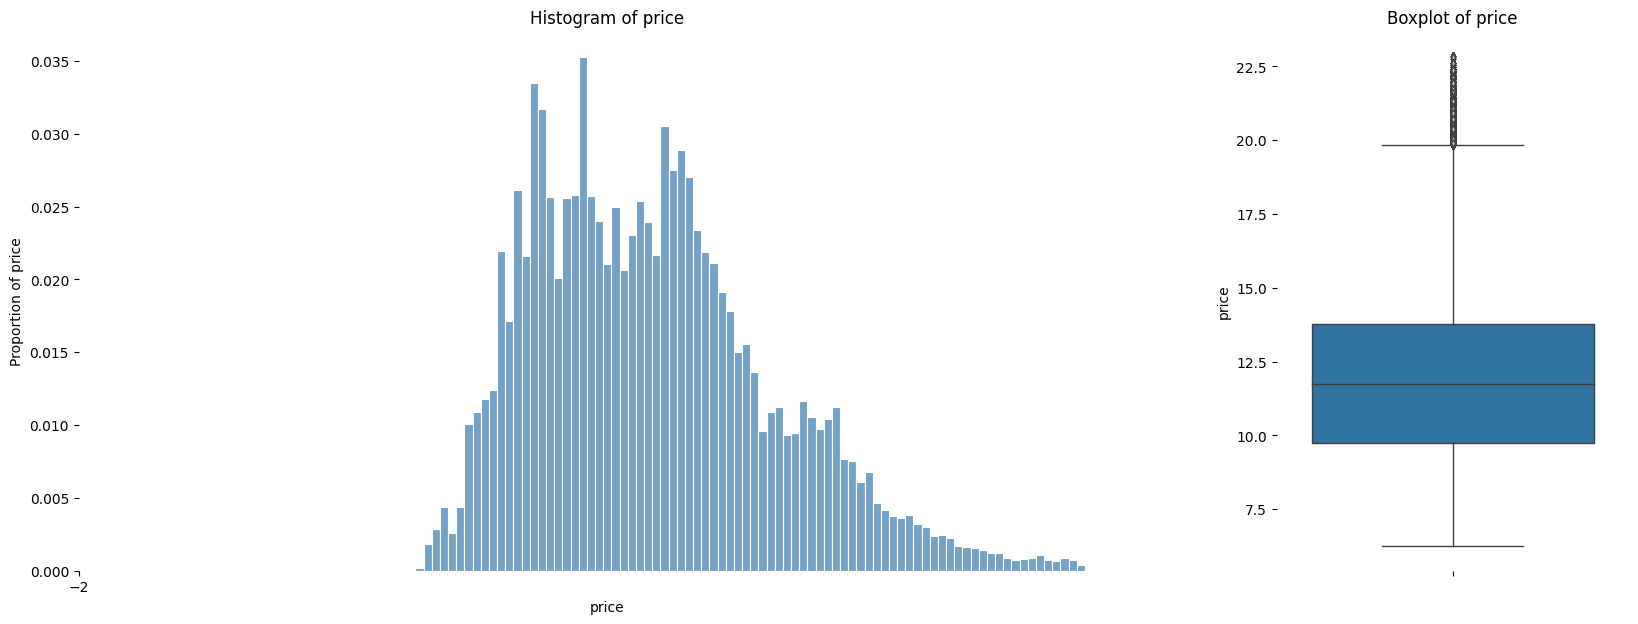

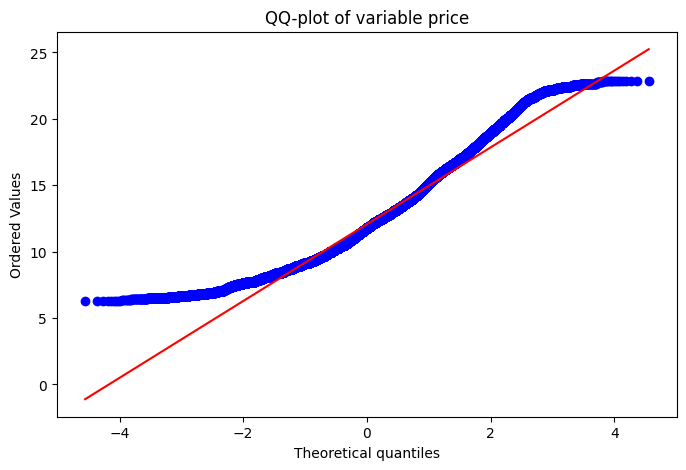

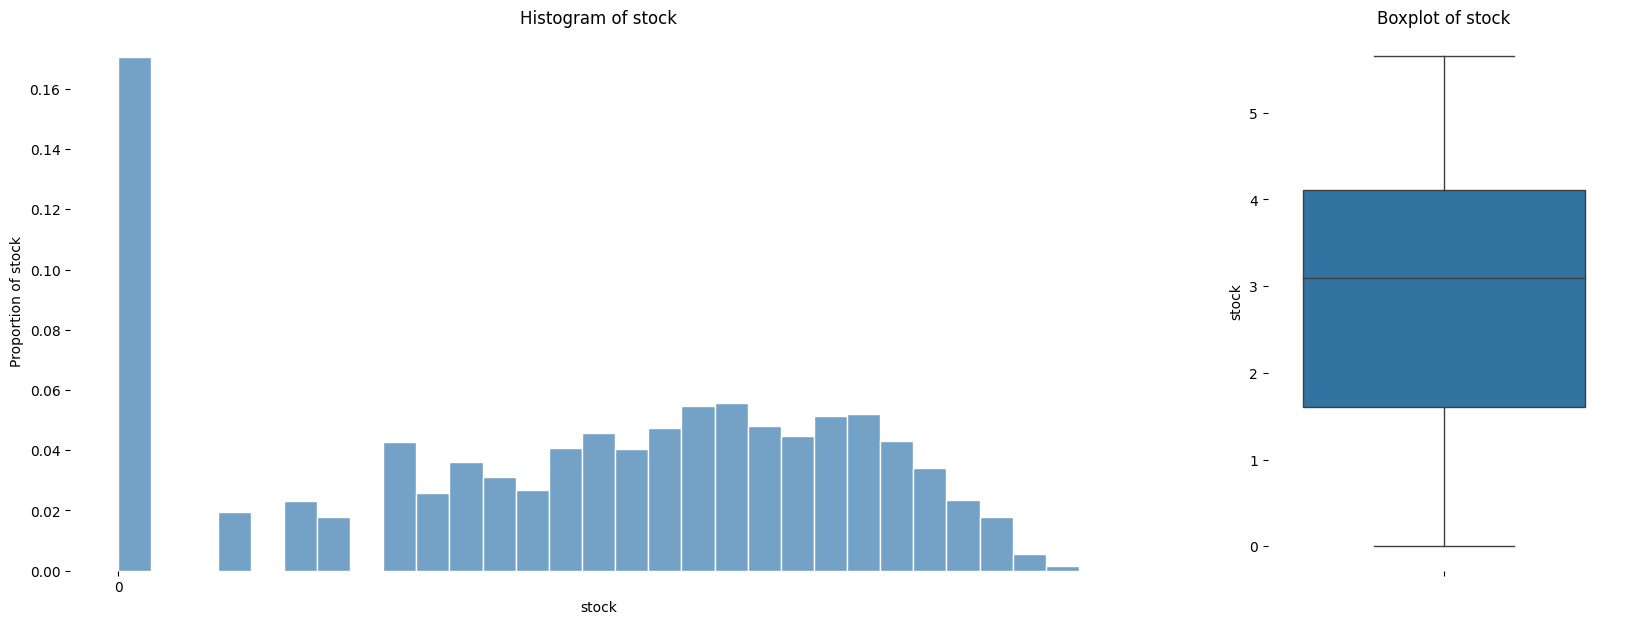

In [14]:
print("========== Distribution des variable après transformation: ==========")
plotHist("price", start = -2, stop = 20, step = 1, bin_width = .2, qqPlot = True)
plotHist("stock",start = 0, stop = 15, step = 1, bin_width = .2, qqPlot = False)

### Variable date

In [58]:
def plotDates():
    """
    Cette fonction trace la répartition de la variable date
    """
    dates_requests = pricing_requests[["request_number","date"]].drop_duplicates()
    
    fig, ax = plt.subplots(figsize=(15,6))

    counts, edges, bars = ax.hist(dates_requests.date,bins=len(dates_requests)//10, density=False,alpha = .5)

    ax.bar_label(bars,padding = 1,size = 12)
    ax.set_xticks(np.arange(0,41))
    ax.set_title("Nombre d'avatars par date de requêtes réalisée")
    ax.set_xlabel("valeur de date")
    ax.set_ylabel("nombre d'occurrences")

    ax.spines[['top','right','left']].set_visible(False)
    plt.show()

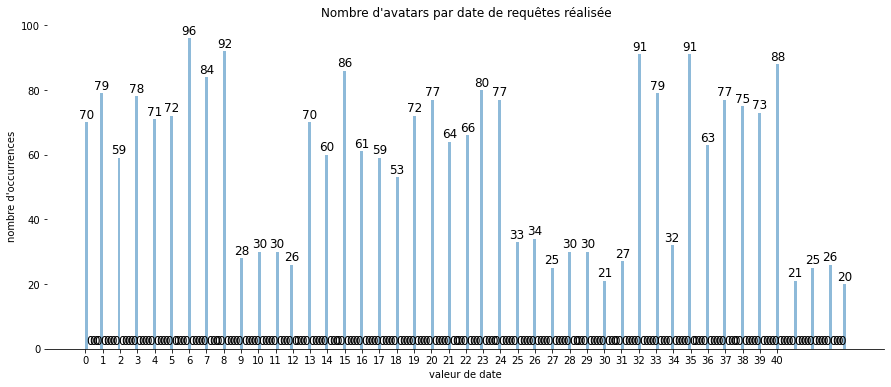

In [59]:
plotDates()

### Transformation des données pour le ML

In [60]:
# Variables explicatives
#-------------------------------------------------
# Liste des variables categorical: 
cat_list1 = ["city", "language", "brand","mobile","parking","pool","children_policy"] #avec brand
cat_list2 = ["city", "language", "group","mobile","parking","pool","children_policy"] #avec group
cat_list3 = ["city", "language", "brand", "group","mobile","parking","pool","children_policy"] #avec brand & group

# Liste des variables quantitatives: 
quant_list1 = ["hotel_id", "stock","request_number", "date"] #on a enlevé avatar_id et price (=variable à expliquer)

# Création de la dataframe train
requests_pricingDum  = pd.get_dummies(pricing_requests[cat_list2],drop_first = True)
request_pricingQuant = pricing_requests[quant_list1]

dfC = pd.concat([requests_pricingDum,request_pricingQuant],axis=1)
dfC.columns

Index(['city_copenhagen', 'city_madrid', 'city_paris', 'city_rome',
       'city_sofia', 'city_valletta', 'city_vienna', 'city_vilnius',
       'language_belgian', 'language_bulgarian', 'language_croatian',
       'language_cypriot', 'language_czech', 'language_danish',
       'language_dutch', 'language_estonian', 'language_finnish',
       'language_french', 'language_german', 'language_greek',
       'language_hungarian', 'language_irish', 'language_italian',
       'language_latvian', 'language_lithuanian', 'language_luxembourgish',
       'language_maltese', 'language_polish', 'language_portuguese',
       'language_romanian', 'language_slovakian', 'language_slovene',
       'language_spanish', 'language_swedish', 'group_Boss Western',
       'group_Chillton Worldwide', 'group_Independant',
       'group_Morriott International', 'group_Yin Yang', 'mobile_1',
       'parking_1', 'pool_1', 'children_policy_1', 'children_policy_2',
       'hotel_id', 'stock', 'request_number', 'date'

In [61]:
# Variable à expliquer 
#-------------------------------------------------
Y = pricing_requests["price"]

Il y a plusieurs façons de diviser notre dataset:


- **Méthode 1**: lorsque l'on a peu de données 

<font color = "blue"> ====================Training================== </font> | <font color = "green"> ====Testing==== </font>\
On se sert de l'échantillon Training pour entraîner notre modèle mais aussi pour tuner les paramètres du modèles et/ou effectuer une sélection de modèles avec la Cross-Validation.\
On ne touche au set de test qu'à la fin, pour obtenir la performance finale.

- **Méthode 2**: lorsque l'on a suffisamment de données 

<font color = "blue"> ===========Training========== </font> <font color = "orange"> ====Validation==== </font> | <font color = "green"> ====Testing==== </font>\
On se sert de l'échantillon Training pour entraîner notre modèle et on tune les paramètres du modèles et/ou effectue une sélection de modèle avec l'échantillon de Validation.\
On ne touche au set de test qu'à la fin, pour obtenir la performance finale. 


Comme nous avons suffisament de données, nous pouvons utiliser la méthode 2 est qui est pratique plus robuste.

In [62]:
# Construction de l'échantillon de test, échantillon de train et échantillon de validation
#-------------------------------------------------
X_train, X_test, Y_train, Y_test = train_test_split(dfC, Y, test_size=0.2, random_state=11)
X_train, X_val, Y_train, Y_val =  train_test_split(X_train, Y_train, test_size=0.25, random_state=11) # 0.25 x 0.8 = 0.2

In [63]:
print("X_train ---> taille: {} x {}".format(X_train.shape[0], X_train.shape[1]))
print("X_val   ---> taille: {}  x {}".format(X_val.shape[0], X_val.shape[1]))
print("X_test  ---> taille: {}  x {}".format(X_test.shape[0], X_test.shape[1]))

X_train ---> taille: 165606 x 48
X_val   ---> taille: 55203  x 48
X_test  ---> taille: 55203  x 48


In [64]:
# Standardisation des variables quantitatives 
#-------------------------------------------------
# standardisation
scaler = StandardScaler()

scaler.fit(X_train)
Xr_train = scaler.transform(X_train)
Xr_val = scaler.transform(X_val)
Xr_test = scaler.transform(X_test)

# transformation de Xr_train et Xr_test (numpy array) en dataframe
Xr_train = pd.DataFrame(Xr_train, index=X_train.index, columns=X_train.columns)
Xr_test = pd.DataFrame(Xr_test, index=X_test.index, columns=X_test.columns)
Xr_val = pd.DataFrame(Xr_val, index=X_val.index, columns=X_val.columns)



In [65]:
filename = 'Standard_Scaler.sav'
pickle.dump(scaler, open(filename, 'wb'))

### Feature Reduction

https://machinelearningmastery.com/feature-selection-with-categorical-data/ => mais il faut que la target variable soit aussi categorical...

#### Method 1: RFECV

RFE (`sklearn.feature_selection.RFE`) select features based on how they affect a particular model’s performance. RFE needs to be given the number of features to select.

It is possible to automatically select the number of features chosen by RFE. This can be achieved by performing cross-validation evaluation of different numbers of features and automatically selecting the number of features that resulted in the best mean score. The RFECV class implements this for us. Remark: the documentation of RFECV says that: "If the estimator is a classifier or if y is neither binary nor multiclass, sklearn.model_selection.KFold is used instead of StartifiedKFold"

Pour appliquer cette méthode, il faut définir un estimateur permettant de donner des `coef_` (ex: SVM, RF, linear regressor...) 

Etant donné qu'il y a beaucoup trop de données pour que la méthode RFECV fonctionne (crée pb espace mémoire), on sélectionne aléatoirement une proportion de données du dataset en espérant que cela représente la globalité des données présentes. 

In [66]:
def reduceDataset(X_t,Y_t,X_v,Y_v,k=10000,per=0.2):
    """
    Cette fonction tire aléatoirement sans remise k éléments dans les datasets donnés
    en argument afin d'en réduire la taille. 
    ---> inputs:
    * X_t,Y_t (pd.DafaFrame): datasets d'entraînement dont il faut réduire la taille. 
    * X_v,Y_v (pd.DafaFrame): datasets de validation dont il faut réduire la taille. 
    * k (int): nombre d'éléments tirés aléatoirement
    * per (float): pourcentage du dataset de validation par rapport au dataset d'entraînement.
    ---> outputs:
    * X_train_small,Y_train_small (pd.DafaFrame): datasets d'entraînement de taille réduite.
    * X_val_small,Y_val_small (pd.DafaFrame): datasets de validation de taille réduite.  
    """
    
    k_train = 10000
    k_val = int(k_train*per)

    indices_train = random.choices(X_t.index, k = k_train)
    indices_val = random.choices(X_v.index,k = k_val)

    X_train_small = X_t.loc[indices_train]
    Y_train_small = Y_t.loc[indices_train]

    X_val_small = X_v.loc[indices_val]
    Y_val_small = Y_v.loc[indices_val]
    
    return X_train_small, X_val_small, Y_train_small, Y_val_small

In [67]:
# Réduction des datasets standardisés
#----------------------------------------------
Xr_train_small, Xr_val_small, Yr_train_small, Yr_val_small = reduceDataset(
    Xr_train,Y_train,Xr_val,Y_val,k=100000,per=0.2)

print("Taille des datasets réduits:")
print("Xr_train_small ---> taille: {} x {}".format(Xr_train_small.shape[0], Xr_train_small.shape[1]))
print("Xr_val_small   ---> taille: {}  x {}".format(Xr_val_small.shape[0], Xr_val_small.shape[1]))
#list(set(X_train_small.index).intersection(X_val_small.index)) #vérifier que l'intersection est vide

Taille des datasets réduits:
Xr_train_small ---> taille: 10000 x 48
Xr_val_small   ---> taille: 2000  x 48


In [68]:
from sklearn.model_selection import RepeatedKFold

In [69]:
# Automatically Select the Number of Features 
#----------------------------------------------
#----- create pipeline
rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=15)
# rfe = RFECV(estimator=DecisionTreeRegressor()) # RFECV automatically selects the number of features
model = DecisionTreeRegressor()
# model = SVR(kernel="poly")
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
#----- evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, Xr_train_small, Yr_train_small, 
                           scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
#----- report performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

KeyboardInterrupt: 

In [26]:
# Print out the  selected features in order of ranking
#------------------------------------------
rfe.fit(Xr_train_small, Yr_train_small)
from operator import itemgetter
features = np.array(Xr_train_small.columns.to_list())
print("Features in order of ranking:")
for x, y in (sorted(zip(rfe.ranking_ , features), key=itemgetter(0))):
    print(x, y)
print("-----------------------------------")
print("The selected {} features are:\n{}".format(rfe.n_features_,features[rfe.support_]))

Features in order of ranking:
1 city_copenhagen
1 city_paris
1 city_sofia
1 city_vilnius
1 group_Boss Western
1 group_Chillton Worldwide
1 group_Independant
1 group_Morriott International
1 group_Yin Yang
1 parking_1
1 pool_1
1 hotel_id
1 stock
1 request_number
1 date
2 city_madrid
3 children_policy_2
4 children_policy_1
5 city_rome
6 city_vienna
7 city_valletta
8 mobile_1
9 language_irish
10 language_latvian
11 language_slovene
12 language_maltese
13 language_italian
14 language_hungarian
15 language_greek
16 language_estonian
17 language_cypriot
18 language_finnish
19 language_german
20 language_slovakian
21 language_czech
22 language_danish
23 language_lithuanian
24 language_polish
25 language_bulgarian
26 language_swedish
27 language_croatian
28 language_luxembourgish
29 language_romanian
30 language_dutch
31 language_spanish
32 language_portuguese
33 language_french
-----------------------------------
The selected 15 features are:
['city_copenhagen' 'city_paris' 'city_sofia' 'city

#### Method 2: 

Cette méthode permet d'eefectuer de la sélection de varible lorsque nous avons des variables explicatives qualitatives et une variable réponse aussi qualitative.\
Nous allons donc appliquer cette méthode uniquement aux variables qualitatives de notre jeu de données et nous allons transformer notre variable réponse qui est quantitative (prix) en une variable qualitative. 

Ici, pas besoin de réduire la taille des datasets car les calculs ne sont pas trop longs.

documentation: https://machinelearningmastery.com/feature-selection-with-categorical-data/

In [ ]:
def categorizeY(Y):
    """
    This function transforms Y (prices) into a categorical variable.
    ---> input:
    * Y (pd.Series): variable continue que l'on veut rendre discrète.
    ---> ouput: 
    * Y_cat (pd.Series): variable discrète. 
    """
    Y_cat = np.zeros(Y.shape).astype(int)

    Y_cat[np.where(Y < 10)] = 0
    Y_cat[np.where((10 <= Y) & (Y < 15))]  = 1
    Y_cat[np.where((15 <= Y) & (Y < 20))]  = 2
    Y_cat[np.where(20 <= Y)]  = 3

    Y_cat = pd.Categorical(Y_cat,ordered=True) 
    Y_cat = pd.Series(Y_cat)
    Y_cat.index = Y.index
    
    return Y_cat

In [ ]:
# Transformation de la variable réponse en variable catégorielle
#----------------------------------------------
Y_train_c = categorizeY (Y_train)
Y_val_c = categorizeY (Y_val)

# On ne garde que les variables qualitatives
#----------------------------------------------
X_train_c = X_train[X_train.columns[:-4]]
X_val_c = X_val[X_val.columns[:-4]]

__Chi-Squared Feature Selection__


Pearson’s chi-squared statistical hypothesis test is an example of a test for independence between categorical variables.
The results of this test can be used for feature selection, where those features that are independent of the target variable can be removed from the dataset.

Plus le Chi2-score est élevé et plus la feature est importante

In [29]:
# Feature selection de k paramètres basée sur le test du Chi2
#----------------------------------------------
chi_2 = SelectKBest(score_func=chi2, k='all') #mettre k='all' si on veut sélectionner toutes les features
chi_2.fit(X_train_c, Y_train_c)

# Dataframe contenant les Chi2-scores de chaque features
#----------------------------------------------
dfScoresChi2 = pd.DataFrame()
dfScoresChi2["feature"] = chi_2.feature_names_in_
dfScoresChi2["score"] =  chi_2.scores_

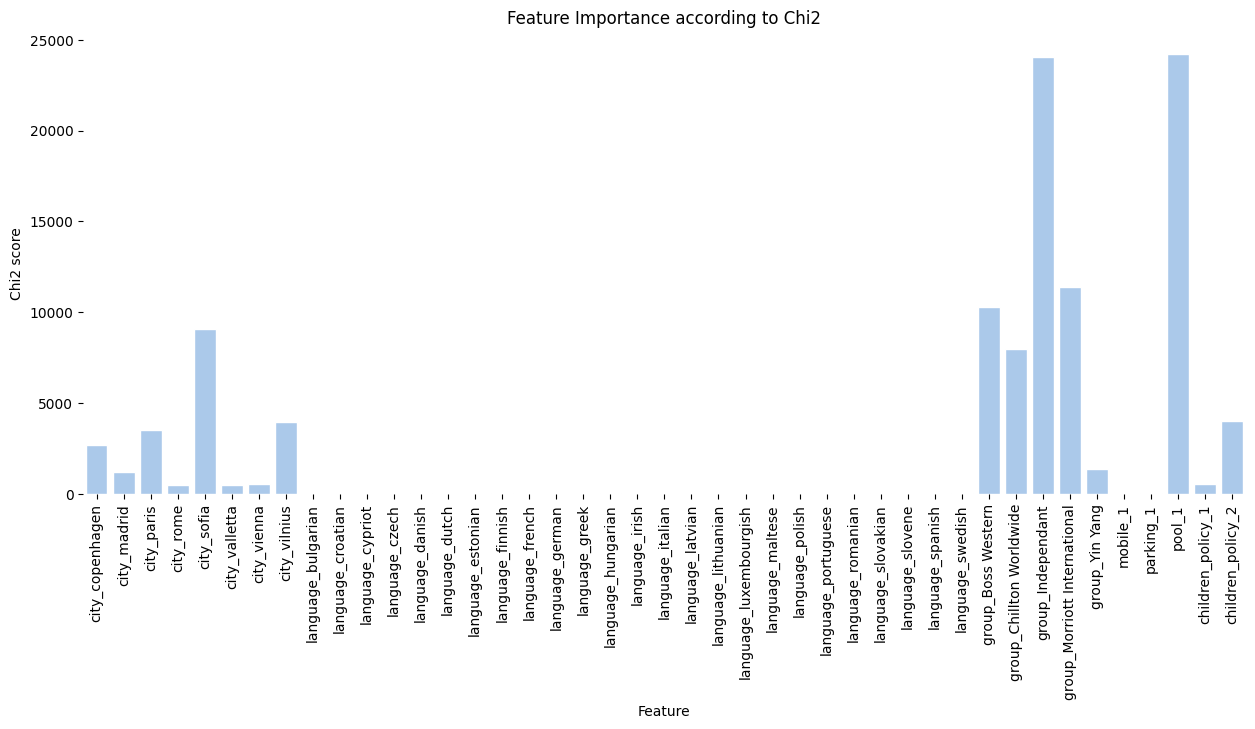

In [30]:
# Tracé de l'importance des features: 
# plus la valeur du score est elevée et plus la feature est importante. 
#----------------------------------------------
f, ax = plt.subplots(figsize=(15, 6))
sns.set_color_codes('pastel')

sns.barplot(ax = ax, x = 'feature', y = 'score', data = dfScoresChi2,
            label = '', color = 'b', edgecolor = 'w')
ax.set(ylabel="Chi2 score", xlabel="Feature")
ax.tick_params(axis='x', rotation=90)
ax.set_title('Feature Importance according to Chi2')
sns.despine(left = True, bottom = True) #remove graph frame
plt.show()

Avec le graphique ci-dessus, on voit que l'on peut sélectionner environ 16 features.

In [31]:
# Sélection de k=16 features avec le Chi2
#----------------------------------------------
chi_2 = SelectKBest(score_func=chi2, k=16) #mettre k='all' si on veut sélectionner toutes les features
chi_2.fit(X_train_c, Y_train_c)
# X_train_chi2 = chi_2.transform(X_train_c)
# X_val_chi2 = chi_2.transform(X_cal_c)

# Affichage des k features sélectionnées 
#----------------------------------------------
chi2_selected = chi_2.get_support(indices=True)
X_train_chi2 = X_train_c.iloc[:,chi2_selected]
X_val_chi2 = X_val_c.iloc[:,chi2_selected]

In [32]:
X_train_chi2.head()

,city_copenhagen,city_madrid,city_paris,city_rome,city_sofia,city_valletta,city_vienna,city_vilnius,group_Boss Western,group_Chillton Worldwide,group_Independant,group_Morriott International,group_Yin Yang,pool_1,children_policy_1,children_policy_2
6625,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
190467,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
97277,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
170603,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
182655,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1


__Mutual Information Feature Selection__ 

Mutual information from the field of information theory is the application of information gain (typically used in the construction of decision trees) to feature selection.

Mutual information is calculated between two variables and measures the reduction in uncertainty for one variable given a known value of the other variable.

In [33]:
# Feature selection de k paramètres basée sur le MI 
#----------------------------------------------
mi = SelectKBest(score_func=mutual_info_classif, k='all') #mettre k='all' si on veut sélectionner toutes les features
mi.fit(X_train_c, Y_train_c)

# Dataframe contenant les Chi2-scores de chaque features
#----------------------------------------------
dfScoresMi = pd.DataFrame()
dfScoresMi["feature"] = mi.feature_names_in_
dfScoresMi["score"] =  mi.scores_

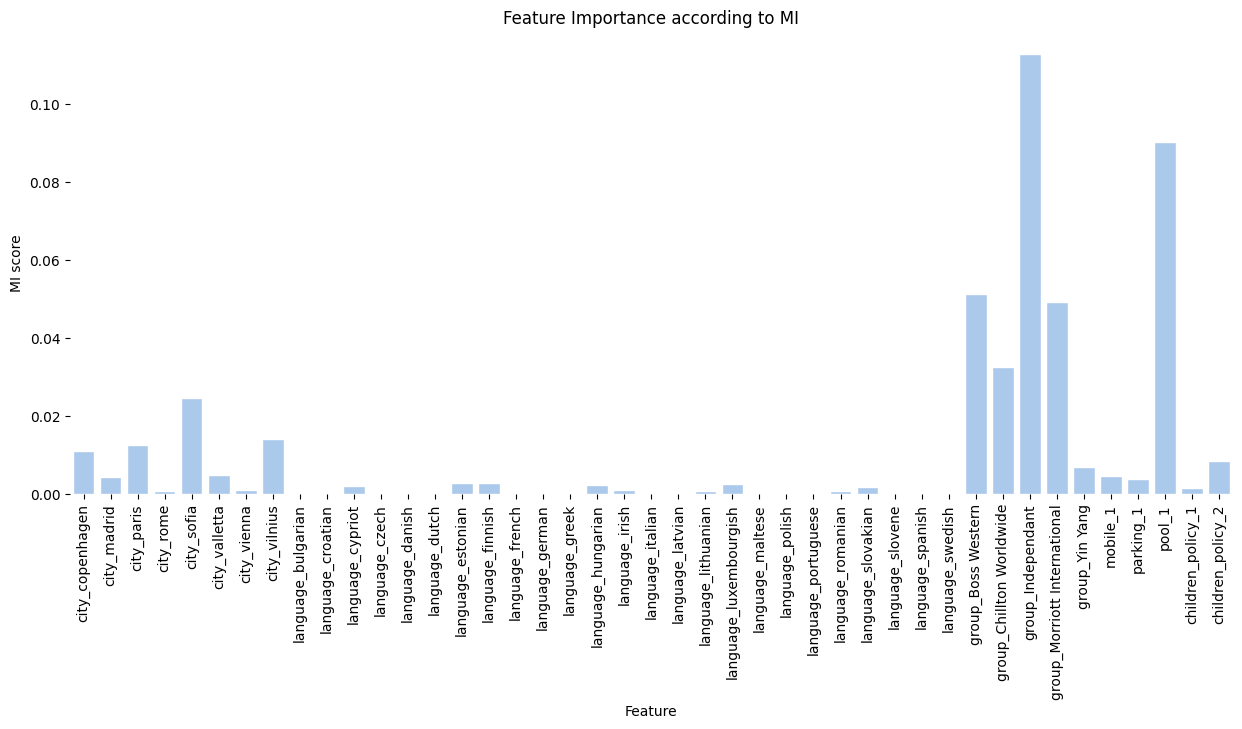

In [34]:
# Tracé de l'importance des features: 
# plus la valeur du score est elevée et plus la feature est importante. 
#----------------------------------------------
f, ax = plt.subplots(figsize=(15, 6))
sns.set_color_codes('pastel')

sns.barplot(ax = ax, x = 'feature', y = 'score', data = dfScoresMi,
            label = '', color = 'b', edgecolor = 'w')
ax.set(ylabel="MI score", xlabel="Feature")
ax.tick_params(axis='x', rotation=90)
ax.set_title('Feature Importance according to MI')
sns.despine(left = True, bottom = True) #remove graph frame
plt.show()

Avec le graphique ci-dessus, on voit que l'on peut sélectionner environ 11 features.

In [35]:
# Sélection de k=16 features avec le Chi2
#----------------------------------------------
mi = SelectKBest(score_func=mutual_info_classif, k=11) #mettre k='all' si on veut sélectionner toutes les features
mi.fit(X_train_c, Y_train_c)

# Affichage des k features sélectionnées 
#----------------------------------------------
mi_selected = mi.get_support(indices=True)
X_train_mi = X_train_c.iloc[:,mi_selected]
X_val_mi = X_val_c.iloc[:,mi_selected]

# Test set d'évaluation kaggle

In [98]:
#récupérer le test set d'évaluation Kaggle
# Lecture du fichier des données tests
#----------------------------------------------
PATH = '.' #modifier si besoin le chemin du fichier

# récupération du fichier contentant l'ensemble des données issues des requêtes
eval_set_kaggle = pd.read_csv(PATH + '//test_set.csv')

# récupération du fichier contenant les features des hotels
hotels = pd.read_csv('features_hotels.csv', index_col=['hotel_id', 'city'])

print("pricing_requests.shape: ",pricing_requests.shape)
pricing_requests.head()# Obtenir des features en plus correspondant aux features de l'hotel : on fait une jointure 
#----------------------------------------------

eval_set_kaggle_detailed = eval_set_kaggle.join(hotels, on=['hotel_id', 'city'])
idx = eval_set_kaggle_detailed ["index"]
del eval_set_kaggle_detailed ["index"]
eval_set_kaggle_detailed.head()
eval_set_kaggle_detailed.rename(columns = {'order_requests':"request_number"}, inplace = True)
eval_set_kaggle_detailed.reindex(columns=['hotel_id','stock','city','date','language','mobile', "avatar_id","request_number" ,"group","brand","parking", "pool","children_policy"])


pricing_requests.shape:  (276012, 14)


,hotel_id,stock,city,date,language,mobile,avatar_id,request_number,group,brand,parking,pool,children_policy
0,161,46,vilnius,21,romanian,0,1,1,Boss Western,J.Halliday Inn,1,0,0
1,187,32,vilnius,21,romanian,0,1,1,Accar Hotels,Marcure,1,1,0
2,279,12,vilnius,21,romanian,0,1,1,Independant,Independant,1,0,0
3,395,10,vilnius,21,romanian,0,1,1,Accar Hotels,Ibas,0,0,0
4,488,42,vilnius,21,romanian,0,1,1,Accar Hotels,Safitel,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6639,987,1,rome,5,irish,0,794,843,Accar Hotels,Ibas,1,0,0
6640,26,1,vienna,1,irish,1,794,844,Accar Hotels,Marcure,1,0,0
6641,263,0,vienna,1,irish,1,794,844,Boss Western,Boss Western,1,0,0
6642,456,0,vienna,1,irish,1,794,844,Yin Yang,Ardisson,1,0,0


In [99]:
print (idx)

0          0
1          1
2          2
3          3
4          4
        ... 
6639    6639
6640    6640
6641    6641
6642    6642
6643    6643
Name: index, Length: 6644, dtype: int64


In [100]:
# Assigner le bon type aux variables
#----------------------------------------------
#--- Convert to integer: 
int_list = ["date","avatar_id","hotel_id","stock","request_number"] 
eval_set_kaggle_detailed[int_list] = eval_set_kaggle_detailed[int_list].astype(int) 
#--- Convert to categorical: 
eval_set_kaggle_detailed["city"] = pd.Categorical(eval_set_kaggle_detailed["city"],ordered=False)
eval_set_kaggle_detailed["language"] = pd.Categorical(eval_set_kaggle_detailed["language"],ordered=False)
eval_set_kaggle_detailed["mobile"] = pd.Categorical(eval_set_kaggle_detailed["mobile"],ordered=False)
eval_set_kaggle_detailed["parking"] = pd.Categorical(eval_set_kaggle_detailed["parking"],ordered=False)
eval_set_kaggle_detailed["pool"] = pd.Categorical(eval_set_kaggle_detailed["pool"],ordered=False)
eval_set_kaggle_detailed["children_policy"] = pd.Categorical(eval_set_kaggle_detailed["children_policy"],ordered=False)
eval_set_kaggle_detailed["group"] = pd.Categorical(eval_set_kaggle_detailed["group"],ordered=False)
eval_set_kaggle_detailed["brand"] = pd.Categorical(eval_set_kaggle_detailed["brand"],ordered=False)

In [101]:
# Variables explicatives
#-------------------------------------------------
# Liste des variables categorical: 
cat_list1 = ["city", "language", "brand","mobile","parking","pool","children_policy"] #avec brand
cat_list2 = ["city", "language", "group","mobile","parking","pool","children_policy"] #avec group
cat_list3 = ["city", "language", "brand", "group","mobile","parking","pool","children_policy"] #avec brand & group

# Liste des variables quantitatives: 
quant_list1 = ["hotel_id", "stock","request_number", "date"] #on a enlevé avatar_id et price (=variable à expliquer)

# Création de la dataframe train
eval_set_kaggle_detailed_pricingDum  = pd.get_dummies(eval_set_kaggle_detailed[cat_list2],drop_first = True)
eval_set_kaggle_detailed_pricingQuant = eval_set_kaggle_detailed[quant_list1]

dfC_eval_set_kaggle = pd.concat([eval_set_kaggle_detailed_pricingDum ,eval_set_kaggle_detailed_pricingQuant],axis=1)
dfC_eval_set_kaggle.columns

Index(['city_copenhagen', 'city_madrid', 'city_paris', 'city_rome',
       'city_sofia', 'city_valletta', 'city_vienna', 'city_vilnius',
       'language_belgian', 'language_bulgarian', 'language_croatian',
       'language_cypriot', 'language_czech', 'language_danish',
       'language_dutch', 'language_estonian', 'language_finnish',
       'language_french', 'language_german', 'language_greek',
       'language_hungarian', 'language_irish', 'language_italian',
       'language_latvian', 'language_lithuanian', 'language_luxembourgish',
       'language_maltese', 'language_polish', 'language_portuguese',
       'language_romanian', 'language_slovakian', 'language_slovene',
       'language_spanish', 'language_swedish', 'group_Boss Western',
       'group_Chillton Worldwide', 'group_Independant',
       'group_Morriott International', 'group_Yin Yang', 'mobile_1',
       'parking_1', 'pool_1', 'children_policy_1', 'children_policy_2',
       'hotel_id', 'stock', 'request_number', 'date'

In [102]:
eval_set_kaggle_detailed

,request_number,city,date,language,mobile,avatar_id,hotel_id,stock,group,brand,parking,pool,children_policy
0,1,vilnius,21,romanian,0,1,161,46,Boss Western,J.Halliday Inn,1,0,0
1,1,vilnius,21,romanian,0,1,187,32,Accar Hotels,Marcure,1,1,0
2,1,vilnius,21,romanian,0,1,279,12,Independant,Independant,1,0,0
3,1,vilnius,21,romanian,0,1,395,10,Accar Hotels,Ibas,0,0,0
4,1,vilnius,21,romanian,0,1,488,42,Accar Hotels,Safitel,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6639,843,rome,5,irish,0,794,987,1,Accar Hotels,Ibas,1,0,0
6640,844,vienna,1,irish,1,794,26,1,Accar Hotels,Marcure,1,0,0
6641,844,vienna,1,irish,1,794,263,0,Boss Western,Boss Western,1,0,0
6642,844,vienna,1,irish,1,794,456,0,Yin Yang,Ardisson,1,0,0


In [103]:
np.unique(eval_set_kaggle_detailed["language"])

array(['austrian', 'belgian', 'bulgarian', 'croatian', 'cypriot', 'czech',
       'danish', 'dutch', 'estonian', 'finnish', 'french', 'german',
       'greek', 'hungarian', 'irish', 'italian', 'latvian', 'lithuanian',
       'luxembourgish', 'maltese', 'polish', 'portuguese', 'romanian',
       'slovakian', 'slovene', 'spanish', 'swedish'], dtype=object)

In [104]:
Xr_eval = scaler.transform(dfC_eval_set_kaggle)

# transformation de Xr_train et Xr_test (numpy array) en dataframe
Xr_eval = pd.DataFrame(Xr_eval, index=dfC_eval_set_kaggle.index, columns=dfC_eval_set_kaggle.columns)

In [76]:
Xr_eval

len(['city_copenhagen', 'city_madrid',
       'city_paris', 'city_rome', 'city_sofia', 'city_valletta', 'city_vienna',
       'city_vilnius', 'language_belgian', 'language_bulgarian',
       'language_croatian', 'language_cypriot', 'language_czech',
       'language_danish', 'language_dutch', 'language_estonian',
       'language_finnish', 'language_french', 'language_german',
       'language_greek', 'language_hungarian', 'language_irish',
       'language_italian', 'language_latvian', 'language_lithuanian',
       'language_luxembourgish', 'language_maltese', 'language_polish',
       'language_portuguese', 'language_romanian', 'language_slovakian',
       'language_slovene', 'language_spanish', 'language_swedish',
       'brand_Ardisson', 'brand_Boss Western', 'brand_Chill Garden Inn',
       'brand_Corlton', 'brand_CourtYord', 'brand_Ibas', 'brand_Independant',
       'brand_J.Halliday Inn', 'brand_Marcure', 'brand_Morriot',
       'brand_Navatel', 'brand_Quadrupletree', 'brand_Royal Lotus',
       'brand_Safitel', 'brand_Tripletree', 'group_Boss Western',
       'group_Chillton Worldwide', 'group_Independant',
       'group_Morriott International', 'group_Yin Yang', 'mobile_1', 'parking_1', 'pool_1', 'children_policy_1','children_policy_2',"hotel_id", "stock", "request_number", "date"])

63

In [105]:
dfC_eval_set_kaggle

,city_copenhagen,city_madrid,city_paris,city_rome,city_sofia,city_valletta,city_vienna,city_vilnius,language_belgian,language_bulgarian,...,group_Yin Yang,mobile_1,parking_1,pool_1,children_policy_1,children_policy_2,hotel_id,stock,request_number,date
0,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,161,46,1,21
1,0,0,0,0,0,0,0,1,0,0,...,0,0,1,1,0,0,187,32,1,21
2,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,279,12,1,21
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,395,10,1,21
4,0,0,0,0,0,0,0,1,0,0,...,0,0,1,1,1,0,488,42,1,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6639,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,987,1,843,5
6640,0,0,0,0,0,0,1,0,0,0,...,0,1,1,0,0,0,26,1,844,1
6641,0,0,0,0,0,0,1,0,0,0,...,0,1,1,0,0,0,263,0,844,1
6642,0,0,0,0,0,0,1,0,0,0,...,1,1,1,0,0,0,456,0,844,1


### Algo 1: XGBoost

In [43]:
#autre version avec gradient boosting 
"""params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor(**params)
reg.fit(X_train, Y_train)
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)"""

'params = {\n    "n_estimators": 500,\n    "max_depth": 4,\n    "min_samples_split": 5,\n    "learning_rate": 0.01,\n    "loss": "squared_error",\n}\nfrom sklearn.ensemble import GradientBoostingRegressor\nreg = GradientBoostingRegressor(**params)\nreg.fit(X_train, Y_train)\ntest_score = np.zeros((params["n_estimators"],), dtype=np.float64)'

In [44]:
"""for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(Y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)

#plt.axvline((np.arange(params["n_estimators"]) + 1)[np.argmin(test_score)])
plt.axvline(200)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance/squared error loss")
fig.tight_layout()
plt.show()"""

'for i, y_pred in enumerate(reg.staged_predict(X_test)):\n    test_score[i] = reg.loss_(Y_test, y_pred)\n\nfig = plt.figure(figsize=(6, 6))\nplt.subplot(1, 1, 1)\nplt.title("Deviance")\nplt.plot(\n    np.arange(params["n_estimators"]) + 1,\n    reg.train_score_,\n    "b-",\n    label="Training Set Deviance",\n)\nplt.plot(\n    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"\n)\n\n#plt.axvline((np.arange(params["n_estimators"]) + 1)[np.argmin(test_score)])\nplt.axvline(200)\nplt.legend(loc="upper right")\nplt.xlabel("Boosting Iterations")\nplt.ylabel("Deviance/squared error loss")\nfig.tight_layout()\nplt.show()'

In [78]:
#!pip install xgboost==1.0.1

In [92]:
# create an xgboost regression model
import xgboost as xgb
model = xgb.XGBRegressor()
model = xgb.XGBRegressor(n_estimators=800, max_depth=10, min_child_weight=4, learning_rate=0.05, subsample=0.9, colsample_bytree=0.7, nthread=4, objective = 'reg:squarederror', silent=0)
model.fit(Xr_train,Y_train) #Xr = données normalisée


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.05, max_delta_step=0, max_depth=10,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             n_estimators=800, n_jobs=4, nthread=4, num_parallel_tree=1,
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             silent=0, subsample=0.9, tree_method=None,
             validate_parameters=False, verbosity=None)

In [97]:
from sklearn.metrics import mean_squared_error
ypred = model.predict(Xr_test)
mse = mean_squared_error(Y_test, ypred)
print("MSE: %.2f" % mse)
print((1-mse)*100, "%")
print(model.score(Xr_test, Y_test))

MSE: 0.06
94.17909654710921 %
0.9933018928268939


In [121]:
print(type(ypred**2))
predict =pd.DataFrame(list(zip(idx, ypred**2)), columns=['index', 'price'])
print (predict)
predict.to_csv('submission.csv', index=False)

<class 'numpy.ndarray'>
      index       price
0         0  216.639069
1         1  181.902557
2         2   78.094170
3         3  195.700485
4         4  226.057877
...     ...         ...
6639   6639  357.129395
6640   6640  248.769623
6641   6641   96.538490
6642   6642  132.744843
6643   6643  114.053421

[6644 rows x 2 columns]


In [95]:
#save le modèle :) 
if tune_hyperparamters :
    filename = 'X_gboost_tuned_model.sav'
    pickle.dump(model, open(filename, 'wb'))

In [96]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(Xr_test, Y_test)
print(result)

0.9933018928268939


In [106]:
pred_eval = loaded_model.predict(Xr_eval)
print(pred_eval)

[12.354084 12.466517  8.751388 ... 11.81051  11.674047 11.965548]


In [49]:
from sklearn.model_selection import GridSearchCV

[0]	validation_0-rmse:10.76739	validation_1-rmse:10.78946
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:9.72612	validation_1-rmse:9.74686
[2]	validation_0-rmse:8.79268	validation_1-rmse:8.81197
[3]	validation_0-rmse:7.95574	validation_1-rmse:7.97382
[4]	validation_0-rmse:7.20661	validation_1-rmse:7.22390
[5]	validation_0-rmse:6.53334	validation_1-rmse:6.55002
[6]	validation_0-rmse:5.93282	validation_1-rmse:5.94776
[7]	validation_0-rmse:5.38957	validation_1-rmse:5.40424
[8]	validation_0-rmse:4.90890	validation_1-rmse:4.92257
[9]	validation_0-rmse:4.47484	validation_1-rmse:4.48718
[10]	validation_0-rmse:4.09357	validation_1-rmse:4.10530
[11]	validation_0-rmse:3.75480	validation_1-rmse:3.76551
[12]	validation_0-rmse:3.45061	validation_1-rmse:3.46007
[13]	validation_0-rmse:3.18311	validation_1-rmse:3.19207
[14]	validation_0-rmse:2.94214	validation_1-rmse:2.

[141]	validation_0-rmse:0.93931	validation_1-rmse:0.94411
[142]	validation_0-rmse:0.93349	validation_1-rmse:0.93907
[143]	validation_0-rmse:0.93314	validation_1-rmse:0.93885
[144]	validation_0-rmse:0.93174	validation_1-rmse:0.93752
[145]	validation_0-rmse:0.92878	validation_1-rmse:0.93482
[146]	validation_0-rmse:0.92369	validation_1-rmse:0.93026
[147]	validation_0-rmse:0.92329	validation_1-rmse:0.93005
[148]	validation_0-rmse:0.92098	validation_1-rmse:0.92794
[149]	validation_0-rmse:0.91576	validation_1-rmse:0.92259
[150]	validation_0-rmse:0.91094	validation_1-rmse:0.91786
[151]	validation_0-rmse:0.90855	validation_1-rmse:0.91572
[152]	validation_0-rmse:0.90620	validation_1-rmse:0.91363
[153]	validation_0-rmse:0.90514	validation_1-rmse:0.91260
[154]	validation_0-rmse:0.90451	validation_1-rmse:0.91224
[155]	validation_0-rmse:0.90160	validation_1-rmse:0.90944
[156]	validation_0-rmse:0.90126	validation_1-rmse:0.90923
[157]	validation_0-rmse:0.89607	validation_1-rmse:0.90421
[158]	validati

[283]	validation_0-rmse:0.68585	validation_1-rmse:0.70073
[284]	validation_0-rmse:0.68538	validation_1-rmse:0.70027
[285]	validation_0-rmse:0.68364	validation_1-rmse:0.69862
[286]	validation_0-rmse:0.68301	validation_1-rmse:0.69795
[287]	validation_0-rmse:0.68247	validation_1-rmse:0.69737
[288]	validation_0-rmse:0.67820	validation_1-rmse:0.69346
[289]	validation_0-rmse:0.67629	validation_1-rmse:0.69162
[290]	validation_0-rmse:0.67565	validation_1-rmse:0.69091
[291]	validation_0-rmse:0.67383	validation_1-rmse:0.68924
[292]	validation_0-rmse:0.67263	validation_1-rmse:0.68811
[293]	validation_0-rmse:0.67119	validation_1-rmse:0.68664
[294]	validation_0-rmse:0.66810	validation_1-rmse:0.68355
[295]	validation_0-rmse:0.66624	validation_1-rmse:0.68179
[296]	validation_0-rmse:0.66408	validation_1-rmse:0.67977
[297]	validation_0-rmse:0.66382	validation_1-rmse:0.67963
[298]	validation_0-rmse:0.66181	validation_1-rmse:0.67794
[299]	validation_0-rmse:0.66092	validation_1-rmse:0.67699
[300]	validati

[425]	validation_0-rmse:0.53419	validation_1-rmse:0.55553
[426]	validation_0-rmse:0.53242	validation_1-rmse:0.55372
[427]	validation_0-rmse:0.53187	validation_1-rmse:0.55312
[428]	validation_0-rmse:0.53178	validation_1-rmse:0.55309
[429]	validation_0-rmse:0.53156	validation_1-rmse:0.55290
[430]	validation_0-rmse:0.53145	validation_1-rmse:0.55287
[431]	validation_0-rmse:0.53090	validation_1-rmse:0.55238
[432]	validation_0-rmse:0.52921	validation_1-rmse:0.55070
[433]	validation_0-rmse:0.52663	validation_1-rmse:0.54826
[434]	validation_0-rmse:0.52566	validation_1-rmse:0.54745
[435]	validation_0-rmse:0.52421	validation_1-rmse:0.54624
[436]	validation_0-rmse:0.52388	validation_1-rmse:0.54590
[437]	validation_0-rmse:0.52344	validation_1-rmse:0.54543
[438]	validation_0-rmse:0.52336	validation_1-rmse:0.54539
[439]	validation_0-rmse:0.52313	validation_1-rmse:0.54527
[440]	validation_0-rmse:0.52243	validation_1-rmse:0.54459
[441]	validation_0-rmse:0.52146	validation_1-rmse:0.54363
[442]	validati

[567]	validation_0-rmse:0.44612	validation_1-rmse:0.47047
[568]	validation_0-rmse:0.44526	validation_1-rmse:0.46975
[569]	validation_0-rmse:0.44488	validation_1-rmse:0.46936
[570]	validation_0-rmse:0.44478	validation_1-rmse:0.46934
[571]	validation_0-rmse:0.44415	validation_1-rmse:0.46879
[572]	validation_0-rmse:0.44362	validation_1-rmse:0.46831
[573]	validation_0-rmse:0.44346	validation_1-rmse:0.46821
[574]	validation_0-rmse:0.44288	validation_1-rmse:0.46760
[575]	validation_0-rmse:0.44276	validation_1-rmse:0.46751
[576]	validation_0-rmse:0.44102	validation_1-rmse:0.46583
[577]	validation_0-rmse:0.44082	validation_1-rmse:0.46565
[578]	validation_0-rmse:0.44007	validation_1-rmse:0.46498
[579]	validation_0-rmse:0.43966	validation_1-rmse:0.46462
[580]	validation_0-rmse:0.43963	validation_1-rmse:0.46460
[581]	validation_0-rmse:0.43889	validation_1-rmse:0.46386
[582]	validation_0-rmse:0.43880	validation_1-rmse:0.46378
[583]	validation_0-rmse:0.43828	validation_1-rmse:0.46324
[584]	validati

[709]	validation_0-rmse:0.37400	validation_1-rmse:0.40184
[710]	validation_0-rmse:0.37392	validation_1-rmse:0.40180
[711]	validation_0-rmse:0.37324	validation_1-rmse:0.40103
[712]	validation_0-rmse:0.37280	validation_1-rmse:0.40065
[713]	validation_0-rmse:0.37238	validation_1-rmse:0.40027
[714]	validation_0-rmse:0.37199	validation_1-rmse:0.39987
[715]	validation_0-rmse:0.37186	validation_1-rmse:0.39975
[716]	validation_0-rmse:0.37078	validation_1-rmse:0.39866
[717]	validation_0-rmse:0.37069	validation_1-rmse:0.39864
[718]	validation_0-rmse:0.37057	validation_1-rmse:0.39856
[719]	validation_0-rmse:0.37052	validation_1-rmse:0.39853
[720]	validation_0-rmse:0.37047	validation_1-rmse:0.39854
[721]	validation_0-rmse:0.37025	validation_1-rmse:0.39831
[722]	validation_0-rmse:0.36999	validation_1-rmse:0.39810
[723]	validation_0-rmse:0.36986	validation_1-rmse:0.39800
[724]	validation_0-rmse:0.36959	validation_1-rmse:0.39778
[725]	validation_0-rmse:0.36926	validation_1-rmse:0.39739
[726]	validati

[851]	validation_0-rmse:0.32863	validation_1-rmse:0.35814
[852]	validation_0-rmse:0.32828	validation_1-rmse:0.35777
[853]	validation_0-rmse:0.32769	validation_1-rmse:0.35715
[854]	validation_0-rmse:0.32759	validation_1-rmse:0.35707
[855]	validation_0-rmse:0.32753	validation_1-rmse:0.35704
[856]	validation_0-rmse:0.32741	validation_1-rmse:0.35691
[857]	validation_0-rmse:0.32684	validation_1-rmse:0.35643
[858]	validation_0-rmse:0.32636	validation_1-rmse:0.35593
[859]	validation_0-rmse:0.32624	validation_1-rmse:0.35583
[860]	validation_0-rmse:0.32621	validation_1-rmse:0.35581
[861]	validation_0-rmse:0.32617	validation_1-rmse:0.35579
[862]	validation_0-rmse:0.32592	validation_1-rmse:0.35555
[863]	validation_0-rmse:0.32569	validation_1-rmse:0.35531
[864]	validation_0-rmse:0.32504	validation_1-rmse:0.35474
[865]	validation_0-rmse:0.32470	validation_1-rmse:0.35438
[866]	validation_0-rmse:0.32463	validation_1-rmse:0.35435
[867]	validation_0-rmse:0.32460	validation_1-rmse:0.35433
[868]	validati

[993]	validation_0-rmse:0.30113	validation_1-rmse:0.33288
[994]	validation_0-rmse:0.30059	validation_1-rmse:0.33234
[995]	validation_0-rmse:0.30013	validation_1-rmse:0.33192
[996]	validation_0-rmse:0.29973	validation_1-rmse:0.33143
[997]	validation_0-rmse:0.29967	validation_1-rmse:0.33138
[998]	validation_0-rmse:0.29963	validation_1-rmse:0.33136
[999]	validation_0-rmse:0.29959	validation_1-rmse:0.33136


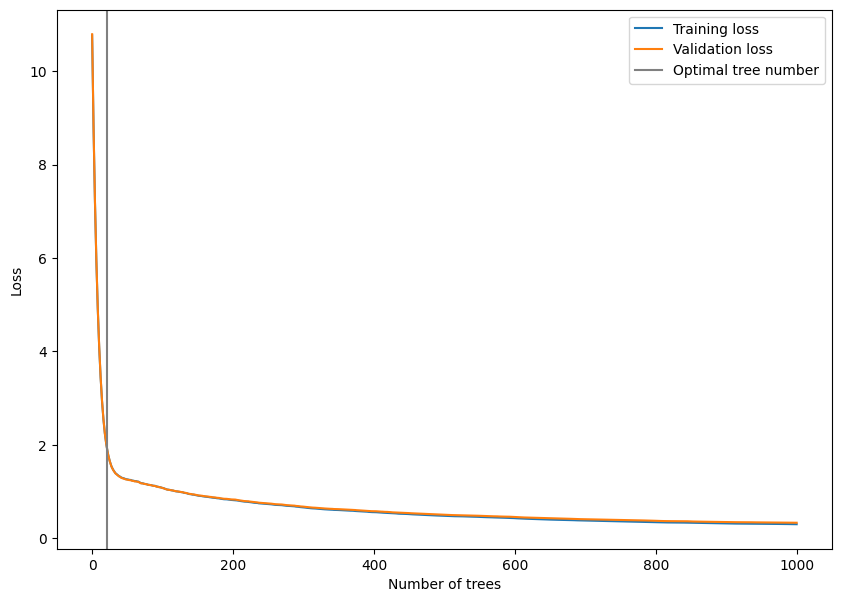

In [50]:
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
if tune_hyperparamters:
#la première étape est de choisir le nombre d'arbres que l'on veut utiliser dans notre modèle de boosting. 
#Pour ce faire, 

    model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=1000, max_depth=6, learning_rate=0.1)
    model.fit(Xr_train, Y_train, 
                eval_set=[(Xr_train, Y_train), (Xr_val, Y_val)], 
                early_stopping_rounds=20) 

    results = model.evals_result()

    plt.figure(figsize=(10,7))
    plt.plot(results["validation_0"]["rmse"], label="Training loss")
    plt.plot(results["validation_1"]["rmse"], label="Validation loss")
    plt.axvline(500, color="gray", label="Optimal tree number")
    plt.xlabel("Number of trees")
    plt.ylabel("Loss")
    plt.legend()
    
# la figure est tout en bas


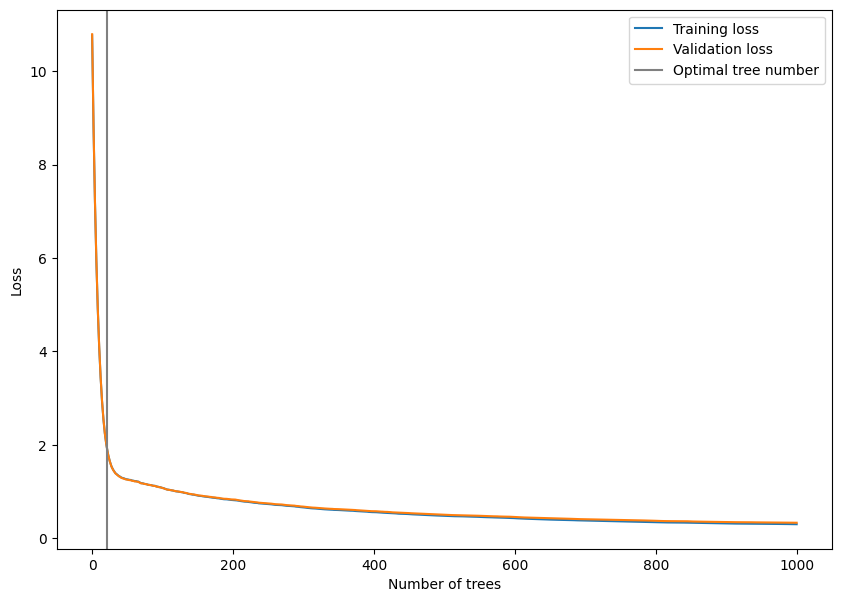

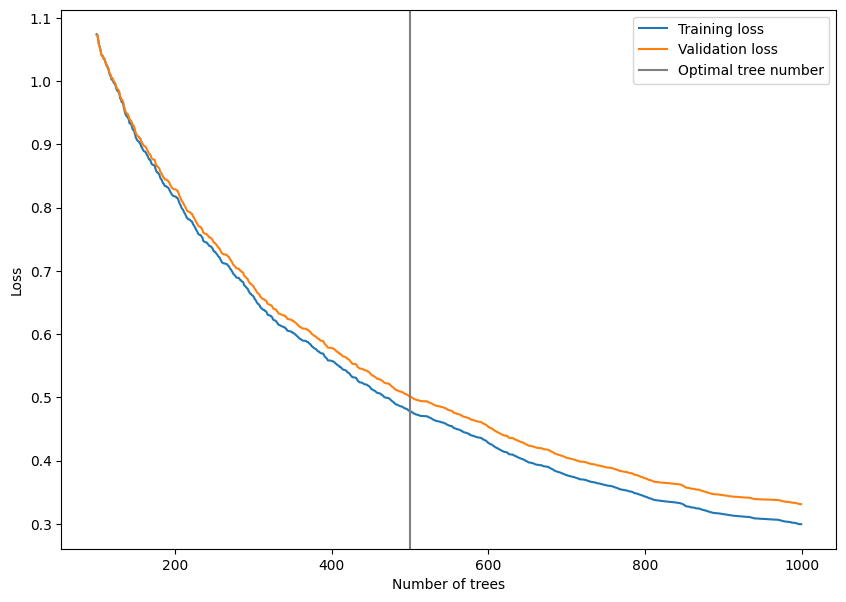

In [52]:
if tune_hyperparamters:
    plt.figure(figsize=(10,7))
    begin=100
    x=np.arange(begin, 1000, 1)
    plt.plot(x, results["validation_0"]["rmse"][begin:], label="Training loss")
    plt.plot(x, results["validation_1"]["rmse"][begin:], label="Validation loss")
    plt.axvline(500, color="gray", label="Optimal tree number")
    plt.xlabel("Number of trees")
    plt.ylabel("Loss")
    plt.legend()

On constate  que la méthode de early stopping ne donne pas des résultats très prononcés. On a que l'erreur de validation et de tests sont tr_s similaires, et ne divergent pas de manière aussi visibles qu'attendu. On est obligé de prendre un très grand nombre d'arbres pour observer le début de cette divergence. En zoomant, on choisit de fixer le nombre d'arbres à 500, de manière à limiter le surapprentissage. 

Ensuite, on réalise une K-fold validation de manière à trouver les paramètres permettant de maximiser la performance. Ici, nous avons préalablement fixé le nombre d'arbres et on a que on cherche à optimiser le taux d'apprentissage et la profondeur maximale des arbres que l'on souhaite construire. 

In [56]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
#on utilise XGboost car il est considéré comme plus précis et plus fiable queGBM (de plus il utilise la prallélisation)
if tune_hyperparamters :

    parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
                  'objective':["reg:squarederror"],#: regression with squared loss.
                  'learning_rate': [0.01, .03, 0.05], #so called `eta` value
                  'max_depth': [5, 10],
                  'min_child_weight': [4],
                  'silent': [0], #only print the warning 
                  'subsample': [0.9],
                  'colsample_bytree': [0.7],
                  'n_estimators': [500]}

    xgb_grid = GridSearchCV(xgb1,
                            parameters,
                            cv = 5,
                            n_jobs = 5,
                            verbose=True)
    xgb_grid.fit(Xr_train,
             Y_train)

    print(xgb_grid.best_score_)



# paramètre optimal
#print("Error la moins élevée = %f, Meilleur paramètre = %s" % (1. -boostOpt.best_score_,boostOpt.best_params_)) #1-R^2


Fitting 5 folds for each of 6 candidates, totalling 30 fits


/home/lea/.local/lib/python3.10/site-packages/xgboost/compat.py:85: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/lea/.local/lib/python3.10/site-packages/xgboost/compat.py:85: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/lea/.local/lib/python3.10/site-packages/xgboost/compat.py:85: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/lea/.local/lib/python3.10/site-packages/xgboost/compat.py:85: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate

KeyboardInterrupt: 

In [ ]:
xgb_grid.best_params_

In [ ]:
# create an xgboost regression model

import xgboost as xgb
xgboost_model_tuned = xgb.XGBRegressor(colsample_bytree= 0.7, learning_rate= 0.05,max_depth=10,min_child_weight= 4,
 n_estimators= 500,nthread= 4,objective ='reg:squarederror',silent= 0,subsample=0.9)
xgboost_model_tuned.fit(Xr_train,Y_train)

In [ ]:
xgboost_model_tuned.score(Xr_test, Y_test)

In [ ]:
#save le modèle :) 
if tune_hyperparamters :
    filename = 'X_gboost_tuned_model.sav'
    pickle.dump(xgboost_model_tuned, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(Xr_test, Y_test)
print(result)

In [ ]:
X_test.shape

### Algo 2 : Random forest

In [123]:
from sklearn.ensemble import RandomForestRegressor
# définition des paramètres
forest = RandomForestRegressor(n_estimators=500, 
    max_depth=None,
    min_samples_split=2, min_samples_leaf=1, 
    max_features='auto', max_leaf_nodes=None,
    bootstrap=True, oob_score=True)
# apprentissage
rfFitreg = forest.fit(Xr_train,Y_train) 
print("erreur out of bag", 1-rfFitreg.oob_score_) #on calcule l'erreur out of bag. 

TypeError: __init__() got an unexpected keyword argument 'n_thread'

In [89]:
importances = rfFitreg.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print(dfC.columns[indices[f]], importances[indices[f]])

NameError: name 'rfFitreg' is not defined

In [90]:


plt.figure(figsize=((15,10)))
plt.bar(list(dfC.columns[indices]), importances[indices],1, color='g', edgecolor="g", alpha=0.25)
plt.title("Importances des variables")
plt.ylabel("importance (probably based on mean decrease in impurity)")
plt.xticks(rotation=90)
plt.show()



NameError: name 'indices' is not defined

<Figure size 1080x720 with 0 Axes>

In [91]:
 1-rfFitreg.score(Xr_test,Y_test)

NameError: name 'rfFitreg' is not defined